# Accumulation, Ablation, Mass Balance and Ice Flow

Goals of this notebook:

- gain a basic understanding of accumulation, ablation and glacier mass balance
- understand the link between mass balance and ice flow
- implement a simple experiment to calculate ice flow on a glacier in equilibrium

In [1]:
import oggm
from oggm import cfg
import oggm_edu as edu
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
from IPython.display import Image
from functools import partial

In [53]:
# set default font size in plots
plt.rc('font', size=16)

The following sections are based on the book *"The Physics of Glaciers"* by Cuffey and Paterson, (2010).

## Accumulation processes

Accumulation processes are all processes that add snow or ice to a glacier (surface). The most important accumulation processes are listed below in order of their relative importance:

- Solid precipitation (snowfall)

    Snowfall varies substantially with latitude and altitude, where the primary factors determining snowfall rates are:

    - **Water vapor content** governed by the [Clausius-Clapeyron-relantionship](https://en.wikipedia.org/wiki/Clausius%E2%80%93Clapeyron_relation#Applications): the warmer the air, the more water it can hold and hence the more precipitation can form

    - **Stratification** of the atmosphere: a subfreezing layer in the lower atmosphere is required for precipitation to reach the ground in solid form

    - **Cooling rate**: high snowfall rates occur where snow is rapidly cooled, e.g. in frontal systems or via orographic lifting

- Redistribution by wind and avalanching

    Accumulation may differ from snowfall due to winds advecting snow over a glacier surface - the interaction between wind and the topography creates regions of snow assimilation and deposition. Furthermore, avalanches may accumulate unusually large amounts of snow in favorable zones. Avalanching is particularly important for mountain glaciers in steep valleys.

- Refreezing of meltwater

    Refreezing of meltwater can either occur at the glacier surface or inside the glacier body, where it is commonly called englacial or internal accumulation. Refreezing meltwater does not explicitly contribute to glacier mass balance, but it has to be subtracted from the total melt to assess the net runoff.

- Deposition

    Deposition refers to processes directly accumulating water or water vapor to the glacier surface, i.e. freezing rain and resublimation.

## Ablation processes

Ablation processes are all processes that remove snow or ice from a glacier. The most important ablation processes are listed below in order of their relative importance:

- Melt and runoff
    
    Melt and runoff account for most glacier mass loss and are driven by the net energy imbalance between the atmosphere and the glacier surface. The most important contributors are the net radiation and the turbulent fluxes of sensible and latent heat. Once the temperature of the glacier surface is at the melting point, i.e. the glacier surface was sufficiently heated, melts rates increase in proportion to the net energy flux.

- Sublimation

    Sublimation refers to the phase change from solid state to gaseous state, e.g. the direct transition of snow and ice to water vapor. It is the dominant source of mass loss in environments where surface temperatures hardly reach the melting point. Sublimation increases with increasing surface temperature and wind speed and with decreasing humidity, hence, it is strongest in dry and warm environments.
    Melt and sublimation can counteract each other: as sublimation consumes energy and transforms it to latent heat, the energy available for melt decreases.

- Calving

    Calving is the separation of ice blocks from a glacier’s margin. Most calving occurs at margins of glaciers that stand or float in water. Calving of glaciers terminating in the ocean, so called *tidewater* glaciers, accounts for much of the mass loss, e.g. for more than 90% of the ablation from Antarctica and about half of the ablation from Greenland. The process is also significant for mountain glaciers that terminate in deep lakes or the ocean.

This nice graphic from [antarcticglaciers.org](http://www.antarcticglaciers.org/) summarizes the different accumulation and ablation processes:

In [2]:
Image(url='http://cdn.antarcticglaciers.org/wp-content/uploads/2018/11/glaciers-as-a-system.png', width=900)

## Mass balance

The rates of accumulation and ablation processes, summed over the glacier and over time, determine the *glacier mass balance* $\dot{m}$, the change in total mass of snow and ice,

$$\dot{m} = \text{accumulation} + \text{ablation}.$$

Mass is continuously redistributed in a glacier: accumulated mass at the top of the glacier is transported downglacier, which is indicated by the black arrow in the figure above. The driving force of this *ice flow* is gravity. Thus, the mass balance of a region on a glacier depends not only on the mass exchanges induced by accumulation and ablation, but also on the gravity driven transport of ice from the acccumulation area to the ablation area.

Generally, mass balance and ice flux are linked via the continuity equation, which implies mass conservation,

$$\frac{\partial H}{\partial t} = \dot{m} - \nabla \cdot \vec{q},$$

where $H$ is the ice thickness, $\dot{m}$ the mass balance and $\vec{q}$ the ice flux.

## Accumulation, ablation and ice flow with OGGM

In [3]:
cfg.initialize()

2019-07-11 17:43:22: oggm.cfg: Using configuration file: C:\Program Files\Miniconda3\envs\oggm_env\lib\site-packages\oggm\params.cfg


In this example, we will essentially reconstruct the series of images [here](http://edu.oggm.org/en/latest/glacier_basics.html#) using OGGM.

### Set the scene

In the introduction on the OGGM-Edu [website](http://edu.oggm.org/en/latest/glacier_basics.html), a cross section of a typical mountain glacier is shown.

In [4]:
Image(url='https://raw.githubusercontent.com/OGGM/glacier-graphics/master/glacier_intro/png/glacier_01.png', width=600)

Such a glacier can be reconstructed in OGGM, as done in the [flowline model notebook](flowline_model.ipynb). First, we define a linear bedrock profile:

In [5]:
# define horizontal resolution of the model:
# nx: number of grid points
# map_dx: grid point spacing in meters
nx = 200
map_dx = 100

In [6]:
# define glacier top and bottom altitudes in meters
top = 3400
bottom = 0

In [7]:
# create a linear bedrock profile from top to bottom
bed_h, surface_h = edu.define_linear_bed(top, bottom, nx)

In [8]:
# calculate the distance from the top to the bottom of the glacier in km
distance_along_glacier = edu.distance_along_glacier(nx, map_dx)

To initialize the glacier, we need to specify how wide the glacier is. Here, we will use a wider accumulation area and a narrow ablation area, typical for mountain glaciers. The accumulation area is determined by the following thresholds of its width at the top of the glacier, the width at the [equilibrium line altitude](http://www.antarcticglaciers.org/glacier-processes/introduction-glacier-mass-balance/#attachment_3396) and the vertical extent downglacier:

In [9]:
# glacier width at the top of the accumulation area: m
ACCW = 1500

In [10]:
# glacier width at the equilibrium line altitude: m
ELAW = 500

In [11]:
# fraction of vertical grid points occupied by accumulation area
NZ = 1 / 3

In [12]:
# accumulation area occupies a fraction NZ of the total glacier extent
acc_width = np.linspace(ACCW, ELAW, int(nx * NZ))

In [13]:
# ablation area occupies a fraction 1 - NZ of the total glacier extent
abl_width = np.tile(ELAW, nx - len(acc_width))

In [14]:
# glacier widths profile
widths = np.hstack([acc_width, abl_width])

The following function provides a 3D-view on the glacier geometry:

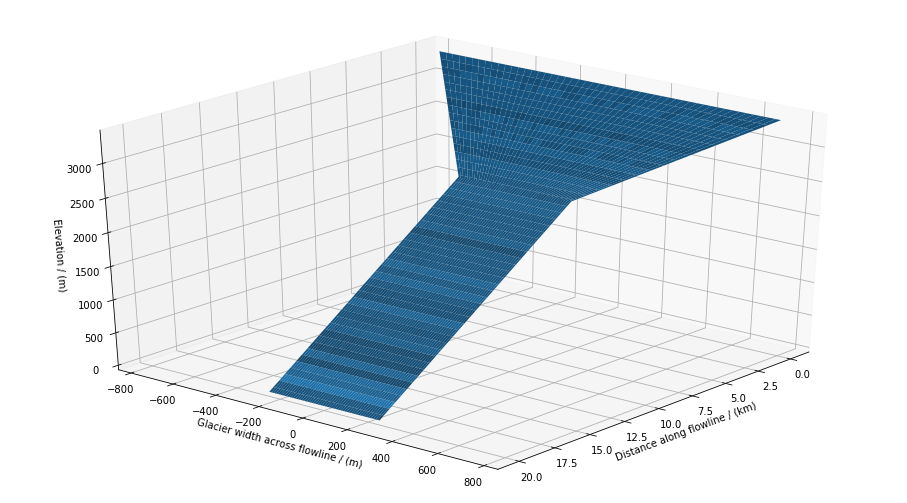

In [15]:
edu.plot_glacier_3d(distance_along_glacier, bed_h, widths, nx);

The upper part of the glacier linearly decreases in width and the lower part of the glacier has constant width. For the model run, the widths have to be converted to grid point space.

In [16]:
# model widths
mwidths = np.zeros(nx) + widths / map_dx

Now, we need to define a glacier bedrock shape - here, we use a rectangular bed:

In [17]:
# define the glacier bed
init_flowline = oggm.core.flowline.RectangularBedFlowline(surface_h=surface_h, bed_h=bed_h, widths=mwidths, map_dx=map_dx)

Then we will need a mass balance model. In our case this will be a simple linear mass balance, defined by the equilibrium line altitude (ELA) and a linear mass balance gradient with respect to elevation (in [mm m$^{-1}$]). The equilibrium line altitude is located at the transition between the accumulation and ablation zone:

In [18]:
# equilibrium line altitude: height where the glacier width first hits ELAW
ela = bed_h[np.where(widths==ELAW)[0][0]]
print('ELA: {:.2f} m'.format(ela))

ELA: 2289.45 m


In [19]:
# mass balance gradient with respect to elevation in mm w.e. m^-1 yr^-1
mb_grad = 7
mb_model = oggm.core.massbalance.LinearMassBalance(ela, grad=mb_grad)

Now that we have all the ingredients to run the model, we just have to initialize it:

In [20]:
# The model requires the initial glacier bed, a mass balance model, and an initial time (the year y0)
model = oggm.core.flowline.FluxBasedModel(init_flowline, mb_model=mb_model, y0=0., min_dt=0, cfl_number=0.01)

Let's run the model until our test glacier is in equilibrium.

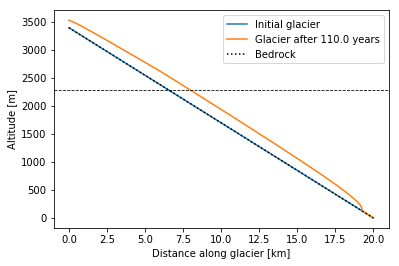

In [21]:
model.run_until_equilibrium()
edu.glacier_plot(x=distance_along_glacier, bed=bed_h, model=model, mb_model=mb_model, init_flowline=init_flowline)

The glacier surface along the defined flowline is:

In [22]:
initial = model.fls[-1].surface_h

**Exercise**: try to change the glacier geometry parameters ``ACCW``, ``ELAW`` and ``NZ``. Do you think a wider/narrower glacier will reach equilibrium faster/slower? Analogously to the [mass balance gradient notebook](mass_balance_gradients.ipynb), check the influence of the mass balance altitude gradient ``mb_grad`` on the time it takes the glacier to reach equilibrium. To get you started, here is a helper function repeating the commands in this section based on your choice of ``ACCW``, ``ELAW``, ``NZ`` and ``mb_grad``.

In [23]:
?edu.linear_mb_equilibrium

Signature:
edu.linear_mb_equilibrium(
    bed,
    surface,
    accw,
    elaw,
    nz,
    mb_grad,
    nx,
    map_dx,
    plot=True,
)
Docstring:
Runs the OGGM FluxBasedModel with a linear mass balance
gradient until the glacier reaches equilibrium.

Parameters
----------
bed : ndarray
    the glacier bed
surface : ndarray
    the initial glacier surface
accw : int
    the width of the glacier at the top of the accumulation area
elaw : int
    the width of the glacier at the equilibrium line altitude
nz : float
    fraction of vertical grid points occupied by accumulation area
mb_grad : int, float
    the mass balance altitude gradient in mm w.e. m^-1 yr^-1
nx : int
    number of grid points
map_dx : int
    grid point spacing
plot : bool
    show a pseudo-3d plot of the glacier geometry

Returns
-------
model : oggm.core.flowline.FluxBasedModel
    OGGM model class of the glacier in equilibrium
File:      c:\oggm-edu\git\oggm-edu\oggm_edu\funcs.py
Type:      function


In [24]:
# this is how to use it
# your_model = edu.linear_mb_equilibrium(bed_h, surface_h, your_accw, your_elaw, your_nz, your_mb_grad, nx, map_dx)

In [25]:
# print('Glacier in equilibrium after: {:.0f} years'.format(your_model.yr))

### Accumulation and Ablation

For a glacier to be in equilibrium, we require the mass balance (accumulation + ablation) to be zero over an integration period. To check this requirement, we can use the mass balance model to compute the annual mass balance and compute a width weighted average over all altitudes:

In [26]:
# annual mass balance: m s^-1
annual_mb = mb_model.get_annual_mb(initial)

In [27]:
# mass balance at each altitude at the particular year of the equilibrium surface: m yr^-1
gmb = annual_mb * cfg.SEC_IN_YEAR

In [28]:
# width weighted glacier mass balance: m yr^-1
weighted_mb = np.average(gmb, weights=mwidths)

In [29]:
print('Total glacier mass balance: {:.2f} m yr^-1'.format(weighted_mb))

Total glacier mass balance: -0.46 m yr^-1


In the previous section, we defined a constant mass balance gradient with height

$$\frac{\partial \dot{m}}{\partial z} = c,$$

which after integration gives

$$\dot{m}(z) = \dot{m}(z_0) + c (z - z_0).$$

For simplicity, we choose the reference height $z_0$ to be the height of the equilibrium line altitude and hence $\dot{m}(z_0) = 0$. Hence, the mass balance model essentially computes

$$\dot{m}(z) = c(z - \text{ela}).$$

Assume, that this glacier now gains mass over the accumulation season - the mass gain increases linearly with height from the terminus to the top as shown in the image below:

In [30]:
Image(url='https://raw.githubusercontent.com/OGGM/glacier-graphics/master/glacier_intro/png/glacier_03.png', width=600)

We define a number of years for which the accumulation is constant:

In [31]:
# accumulation at the glacier terminus: m w.e. yr^-1
acc_0 = 0

In [32]:
# glacier terminus
terminus = initial[initial <= bed_h][0]

In [33]:
# accumulation as a function of altitude in one year: m w.e. yr^-1
# scaled by the model glacier widths
acc = acc_0 + mb_grad * (initial[initial >= terminus] - terminus) * 1e-3 * mwidths[initial >= terminus]

In [34]:
# append 0 accumulation downstream of glacier terminus
acc_d = np.hstack([acc, np.zeros(len(initial[initial < terminus]))])

Applying this accumulation to our initial glacier surface in equilibrium:

In [35]:
acc_sfc = initial + acc_d

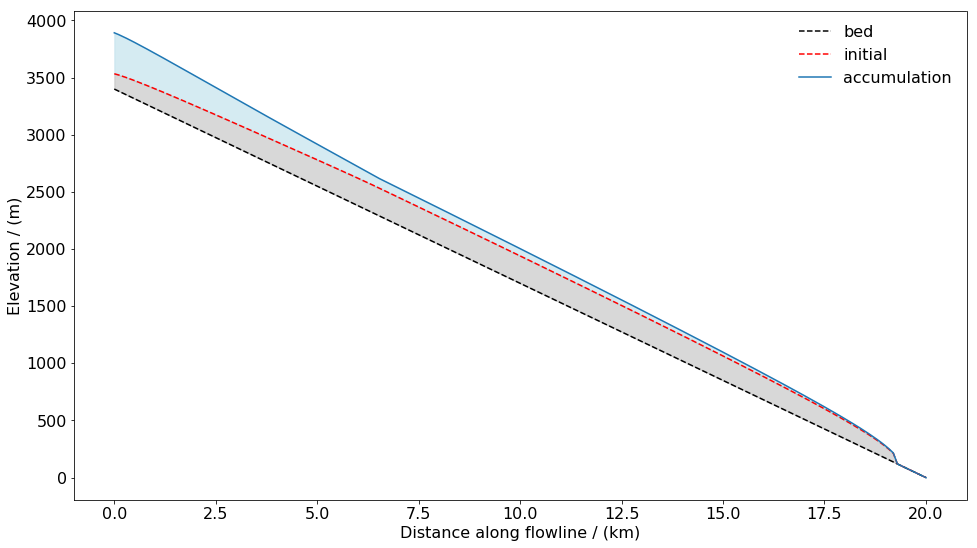

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(distance_along_glacier, bed_h, '--k', label='bed')
ax.plot(distance_along_glacier, initial, '--r', label='initial')
ax.plot(distance_along_glacier, acc_sfc, '-', label='accumulation')
#ax.hlines(ela, distance_along_glacier[0], distance_along_glacier[-1], linestyle='--', color='grey')
#ax.text(distance_along_glacier[-1], ela + 10, 'Equilibrium line altitude', horizontalalignment='right', verticalalignment='bottom', color='grey')
ax.fill_between(distance_along_glacier, bed_h, initial, color='grey', alpha=0.3);
ax.fill_between(distance_along_glacier, initial, acc_sfc, color='lightblue', alpha=0.5);
ax.legend(frameon=False);
ax.set_xlabel('Distance along flowline / (km)')
ax.set_ylabel('Elevation / (m)');

Next, during the ablation season, the glacier looses mass according to the same linear mass balance gradient.

In [37]:
Image(url='https://raw.githubusercontent.com/OGGM/glacier-graphics/master/glacier_intro/png/glacier_04.png', width=600)

In [38]:
# ablation = accumulation (reversed elevation dependence): m w.e. yr^-1
abl = - acc[::-1]

In [39]:
# append 0 ablation downstream of glacier terminus
abl_d = np.hstack([abl, np.zeros(len(initial[initial < terminus]))])

Applying this accumulation to our initial glacier surface in equilibrium:

In [40]:
# glacier surface after ablation
abl_sfc = initial + abl_d

In [41]:
# correct where ice thickness is less than bedrock
no_ice = np.where(abl_sfc < bed_h)
abl_sfc[no_ice] = bed_h[no_ice]

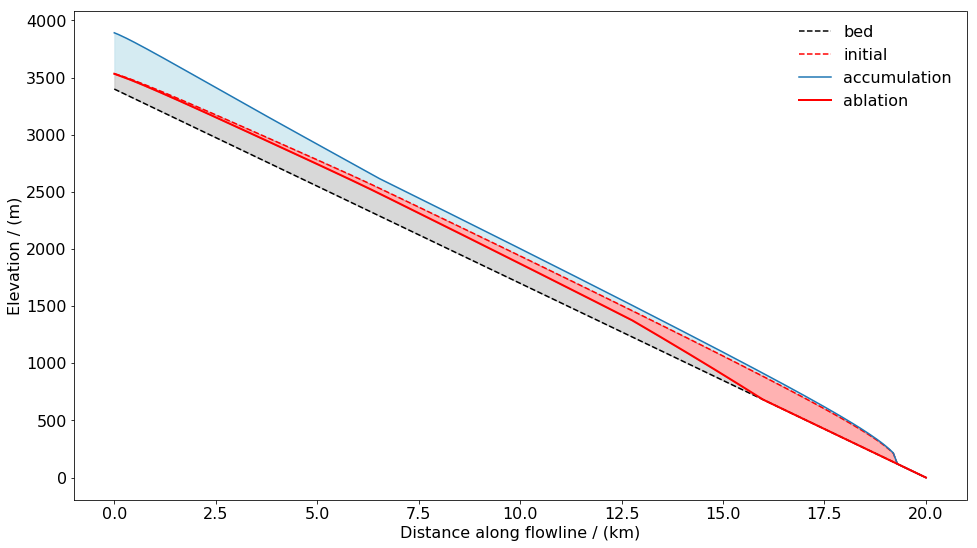

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(distance_along_glacier, bed_h, '--k', label='bed')
ax.plot(distance_along_glacier, initial, '--r', label='initial')
ax.plot(distance_along_glacier, acc_sfc, '-', label='accumulation')
ax.plot(distance_along_glacier, abl_sfc, '-r', linewidth=2, label='ablation')
#ax.hlines(ela, distance_along_glacier[0], distance_along_glacier[-1], linestyle='--', color='grey')
#ax.text(distance_along_glacier[-1], ela + 10, 'Equilibrium line altitude', horizontalalignment='right', verticalalignment='bottom', color='grey')
ax.fill_between(distance_along_glacier, bed_h, abl_sfc, color='grey', alpha=0.3);
ax.fill_between(distance_along_glacier, initial, acc_sfc, color='lightblue', alpha=0.5);
ax.fill_between(distance_along_glacier, initial, abl_sfc, color='red', alpha=0.3);
ax.legend(frameon=False);
ax.set_xlabel('Distance along flowline / (km)')
ax.set_ylabel('Elevation / (m)');

### Mass Balance

The net mass balance is the sum of accumulation and ablation:

In [55]:
Image(url='https://raw.githubusercontent.com/OGGM/glacier-graphics/master/glacier_intro/png/glacier_05.png', width=600)

In [56]:
# net mass balance: m w.e. yr^-1
mb_we = acc_d + abl_d

In [57]:
# add mass balance to initial surface
mb_sfc = initial + mb_we

In [58]:
# correct where ice thickness is less than bedrock
no_ice = np.where(mb_sfc < bed_h)
mb_sfc[no_ice] = bed_h[no_ice]

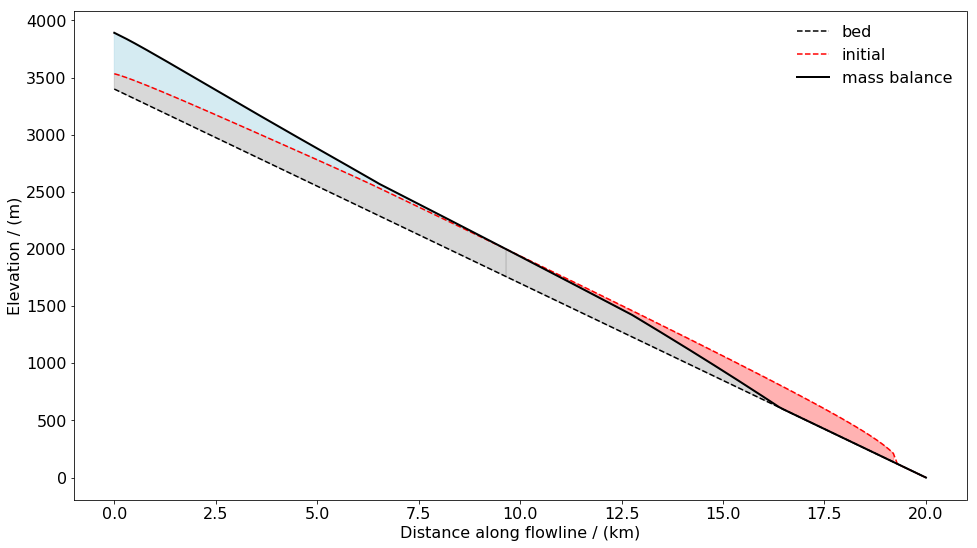

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(distance_along_glacier, bed_h, '--k', label='bed')
ax.plot(distance_along_glacier, initial, '--r', label='initial')
ax.plot(distance_along_glacier, mb_sfc, '-k', linewidth=2, label='mass balance')
#ax.hlines(ela, distance_along_glacier[0], distance_along_glacier[-1], linestyle='--', color='grey')
#ax.text(distance_along_glacier[-1], ela + 10, 'Equilibrium line altitude', horizontalalignment='right', verticalalignment='bottom', color='grey')
ax.fill_between(distance_along_glacier, bed_h, initial, mb_sfc >= initial, color='grey', alpha=0.3);
ax.fill_between(distance_along_glacier, bed_h, mb_sfc, mb_sfc <= initial, color='grey', alpha=0.3);
ax.fill_between(distance_along_glacier, initial, mb_sfc, mb_sfc >= initial, color='lightblue', alpha=0.5);
ax.fill_between(distance_along_glacier, initial, mb_sfc, mb_sfc < initial, color='red', alpha=0.3);
ax.legend(frameon=False);
ax.set_xlabel('Distance along flowline / (km)')
ax.set_ylabel('Elevation / (m)');

In [65]:
# net mass balance
print('Net mass balance: {:.2f} m w.e. yr^-1'.format(np.average(mb_we)))

Net mass balance: 0.00 m w.e. yr^-1


### Ice flux

In [66]:
Image(url='https://raw.githubusercontent.com/OGGM/glacier-graphics/master/glacier_intro/png/glacier_06.png', width=600)

In equilibrium, the ice thickness $H$ does not change with time and the continuity equation reduces to,

$$\dot{m} = \nabla \vec{q}.$$

This means that glacier mass balance solely determines ice flux if the glacier is in steady-state. Hence, the ice flux can be computed by vertically integrating the mass balance - in the one-dimensional case, the ice flux is the sum of the mass balance above a certain reference height $z$.

The ice flux can then by computed by discrete integration of the mass balance:

In [67]:
# convert mass balance to kg m^-2 yr^-1
mb_ice = mb_we * 1000

In [68]:
# ice flux along the defined flowline: kg m^-2 s^-1
q = mb_ice.cumsum() / cfg.SEC_IN_YEAR

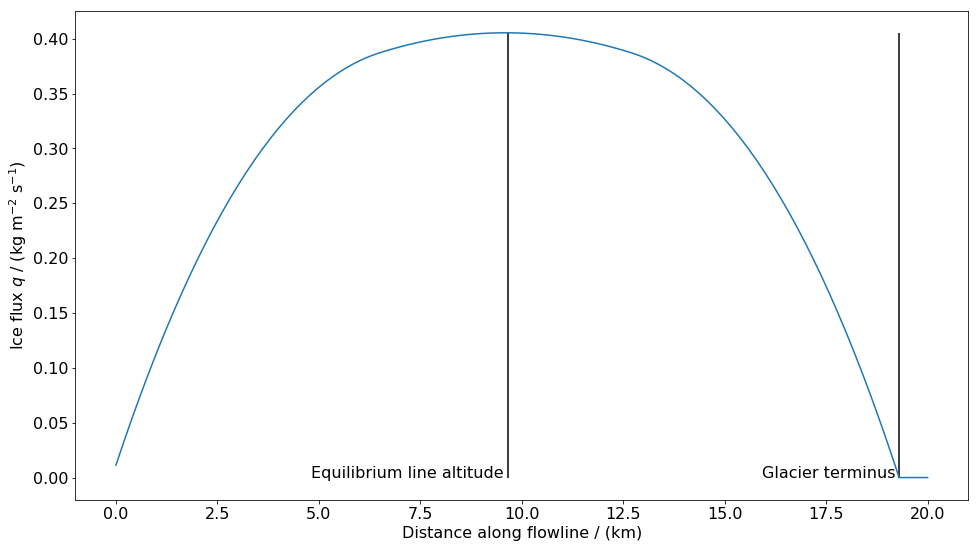

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(distance_along_glacier, q);
ax.vlines(distance_along_glacier[np.where(mb_ice == 0)[0][0]], 0, np.max(q))
ax.text(distance_along_glacier[np.where(mb_ice == 0)[0][0]] - 0.1, 0,
        'Equilibrium line altitude', horizontalalignment='right')
ax.vlines(distance_along_glacier[np.where(q < 1e-10)[0][0]], 0, np.max(q))
ax.text(distance_along_glacier[np.where(q < 1e-10)[0][0]] - 0.1, 0,
        'Glacier terminus', horizontalalignment='right')
ax.set_ylabel('Ice flux $q$ / (kg m$^{-2}$ s$^{-1}$)');
ax.set_xlabel('Distance along flowline / (km)');

By construction, the ice flux is maximal at the equilibrium line altitude and zero at the glacier terminus.

## Take home points

- Accumulation processes are all processes that add snow or ice to a glacier, e.g.
    - Solid precipitation
    - Redistribution of snow by wind and avalanching
    - Refreezing of meltwater
    - Resublimation and freezing rain
- Ablation processes are all processes that remove snow or ice from a glacier, e.g.
    - Melt and runoff
    - Sublimation
    - Calving
- Accumulation and ablation rates determine the glacier mass balance, i.e. the change in total mass of snow and ice.
- Glaciers flow due to gravity
- Mass conservation implies a link between ice thickness, mass balance and ice flow

## References

- K.M. Cuffey and W.S.B. Paterson, (2010). [The Physics of Glaciers](https://www.elsevier.com/books/the-physics-of-glaciers/cuffey/978-0-12-369461-4)

## What's next?

[Back to table of contents](welcome.ipynb)